In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import numpy as np
import numba as nb
import talib
import exercise_util

@nb.jit
def calc_position_return(buy_limit_hit, sell_limit_hit, buy_limit, sell_limit, close, force_exit_steps):
  position = np.empty(buy_limit_hit.shape, dtype=float)
  position[:] = 0.0
  
  ret = np.empty(buy_limit_hit.shape, dtype=float)
  ret[:] = 0.0

  _pos = 0.0
  _entry_price = np.nan
  _entry_step = np.nan

  for i in range(position.size):
    _prev_pos = _pos

    if _prev_pos > 0:
      # 実験用に常に強制イグジット
      _pos = 0.0
      _ret = np.log(close[i]) - np.log(_entry_price)
    elif _prev_pos < 0:
      # 実験用に常に強制イグジット、かつポジションによる損益の正負調整を行わない
      _pos = 0.0
      _ret = np.log(close[i]) - np.log(_entry_price)
    else:
      if buy_limit_hit[i] == True:
        # ロングでエントリー
        _pos = 1.0
        _ret = 0.0
        _entry_price = buy_limit[i]
        _entry_step = i
      elif sell_limit_hit[i] == True:
        # ショートでエントリー
        _pos = -1.0
        _ret = 0.0
        _entry_price = sell_limit[i]
        _entry_step = i
      else:
        # ポジションをそのまま維持
        _pos = _prev_pos
        _ret = 0.0
    
    position[i] = _pos
    ret[i] = _ret
    
  return position, ret

def simulate_atrkun(symbol = None, df_timebar = None, window_size = 14, atr_factor = 0.5, fee = 0.02, force_exit_steps = 0):
    _df_analysis = df_timebar.copy()

    # 1本後の時間足で有効な買指値、売指値を計算してデータフレームに追加
    _df_analysis['atr'] = talib.ATR(_df_analysis['high'], _df_analysis['low'], _df_analysis['close'], timeperiod = window_size) * atr_factor
    _df_analysis['previous_atr'] = _df_analysis['atr'].shift(1)
    _df_analysis['buy_limit'] = (_df_analysis['close'] - _df_analysis['atr']).shift(1)
    _df_analysis['sell_limit'] = (_df_analysis['close'] + _df_analysis['atr']).shift(1)

    _df_analysis['buy_limit_hit'] = _df_analysis['buy_limit'] > _df_analysis['low']
    _df_analysis['sell_limit_hit'] = _df_analysis['sell_limit'] < _df_analysis['high']
    _df_analysis['atr_with_sign'] = 0
    _df_analysis.loc[_df_analysis['buy_limit_hit'] == True, 'previous_atr_with_sign'] = _df_analysis.loc[_df_analysis['buy_limit_hit'] == True, 'previous_atr'] * -1
    _df_analysis.loc[_df_analysis['sell_limit_hit'] == True, 'previous_atr_with_sign'] = _df_analysis.loc[_df_analysis['sell_limit_hit'] == True, 'previous_atr']

    _df_analysis['position'], _df_analysis['trade_logreturn'] = calc_position_return(_df_analysis['buy_limit_hit'].values, _df_analysis['sell_limit_hit'].values, _df_analysis['buy_limit'].values,  _df_analysis['sell_limit'].values, _df_analysis['close'].values, force_exit_steps)
    _df_analysis['position_diff'] = _df_analysis['position'].diff()
    _df_analysis.dropna(inplace = True)
    
    # 実験のために手数料はカウントしない
    _df_analysis['fee'] = 0

    # トレードごとのリターンから手数料を引いて利益を計算
    _df_analysis['profit'] = _df_analysis['trade_logreturn'] - _df_analysis['fee']
    _df_analysis['profit_cumsum'] = _df_analysis['profit'].cumsum()

    # トレードを実行した行のみを抜き出して各種処理を行う
    _df_analysis_tradeonly = _df_analysis[_df_analysis['position_diff'] != 0].copy()
    _df_analysis_tradeonly['time_trade'] = _df_analysis_tradeonly.index
    _df_analysis_tradeonly['interval_trade'] = (_df_analysis_tradeonly['time_trade'].diff() / np.timedelta64(1, "h")).fillna(0).astype(float)
    _df_analysis_tradeonly['profit_trade'] = _df_analysis_tradeonly['profit_cumsum'].diff()

    _df_analysis_tradeonly['gain_trade'] = np.where(_df_analysis_tradeonly['profit_trade'] >= 0, _df_analysis_tradeonly['profit_trade'], 0)
    _df_analysis_tradeonly['loss_trade'] = np.where(_df_analysis_tradeonly['profit_trade'] < 0, _df_analysis_tradeonly['profit_trade'], 0)

    _df_analysis_tradeonly.sort_values(['interval_trade', 'time_trade'], inplace = True)
    _df_analysis_tradeonly.set_index('interval_trade', drop = False, inplace = True)

    # イグジットしたトレードだけを残す
    _df_analysis_tradeonly = _df_analysis_tradeonly.loc[_df_analysis_tradeonly['position'] == 0, :]
    
    _final_profit = _df_analysis['profit_cumsum'].iloc[-1]
    _trade_count = len(_df_analysis_tradeonly)
    _expected_return_per_trade = _df_analysis['profit_cumsum'].iloc[-1] / len(_df_analysis_tradeonly)
    _sd_per_trade = _df_analysis_tradeonly['profit_trade'].std()

    # ATRと指値ヒットしてイグジットした時に限定した符号付きATRとリターンの散布図を描画する
    exercise_util.show_correlation(_df_analysis_tradeonly['previous_atr_with_sign'], _df_analysis_tradeonly['trade_logreturn'], legend_loc = 'lower right')

  0%|          | 0/1149 [00:00<?, ?it/s]

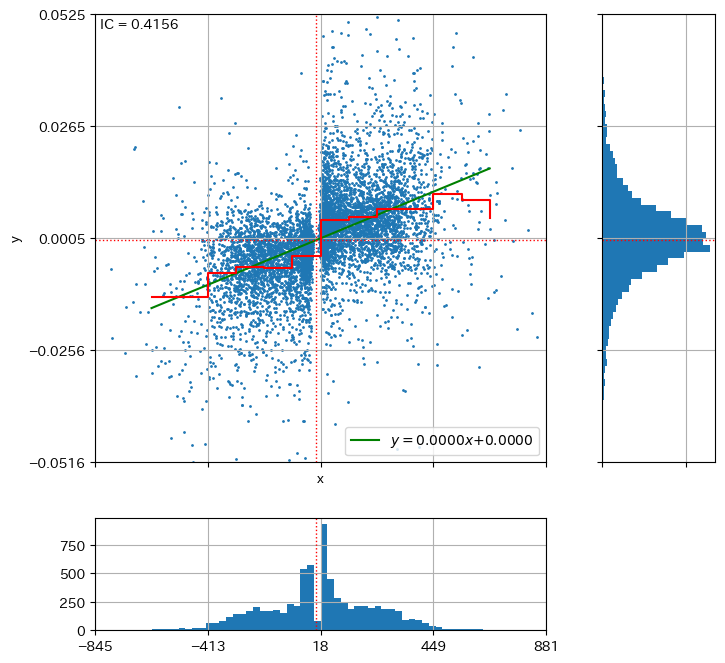

In [13]:
fee = 0.0
df_timebar = exercise_util.concat_timebar_files('BTCUSDT', 3600)
simulate_atrkun('BTCUSDT', df_timebar, window_size = 14, atr_factor = 0.5)